<a href="https://colab.research.google.com/github/andreydesousa92-byte/ML_models/blob/main/Intermitent_Sales_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Describbing Business Case
Sales & order data for Northwind Traders, a fictitious gourmet food supplier, including information on customers, products, orders, shippers, and employees.


## Our Goal!

Because customer demand is inconsistent, we aim to predict the probability that a customer will place an order next month. This allows our sales team to proactively engage with customers who are likely to make a purchase.

# Importing databases

In [1]:
import pandas as pd

In [2]:
# CATEGORIES
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/categories.csv"
df_categories = pd.read_csv(url)
df_categories.head()

,categoryID,categoryName,description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains & Cereals,"Breads, crackers, pasta, and cereal"


In [3]:
# CUSTOMERS
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/customers.csv"
df_customers = pd.read_csv(url, encoding='latin1')
df_customers.head()

,customerID,companyName,contactName,contactTitle,city,country
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Berlin,Germany
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Mexico City,Mexico
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mexico City,Mexico
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,London,UK
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Luleå,Sweden


In [4]:
# ORDERDETAILS
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/order_details.csv"
df_salesorders = pd.read_csv(url, encoding='latin1')
df_salesorders.head()

,orderID,productID,unitPrice,quantity,discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [5]:
# ORDERDES
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/orders.csv"
df_orders = pd.read_csv(url)
df_orders.head()


,orderID,customerID,employeeID,orderDate,requiredDate,shippedDate,shipperID,freight
0,10248,VINET,5,2013-07-04,2013-08-01,2013-07-16,3,32.38
1,10249,TOMSP,6,2013-07-05,2013-08-16,2013-07-10,1,11.61
2,10250,HANAR,4,2013-07-08,2013-08-05,2013-07-12,2,65.83
3,10251,VICTE,3,2013-07-08,2013-08-05,2013-07-15,1,41.34
4,10252,SUPRD,4,2013-07-09,2013-08-06,2013-07-11,2,51.30


In [6]:
# Min and Max dates
min_date = df_orders['orderDate'].min()
max_date = df_orders['orderDate'].max()

print("Min order date:", min_date)
print("Max order date:", max_date)

Min order date: 2013-07-04
Max order date: 2015-05-06


In [7]:
# Create date range
calendar_df = pd.DataFrame({'Date': pd.date_range(start=min_date, end=max_date)})

# Extract year and month as separate columns
calendar_df['Year'] = calendar_df['Date'].dt.year
calendar_df['Month'] = calendar_df['Date'].dt.month
calendar_df['Day'] = calendar_df['Date'].dt.day

calendar_df.head(10)

,Date,Year,Month,Day
0,2013-07-04,2013,7,4
1,2013-07-05,2013,7,5
2,2013-07-06,2013,7,6
3,2013-07-07,2013,7,7
4,2013-07-08,2013,7,8
5,2013-07-09,2013,7,9
6,2013-07-10,2013,7,10
7,2013-07-11,2013,7,11
8,2013-07-12,2013,7,12
9,2013-07-13,2013,7,13


In [8]:
# ORDERDETAILS
url = "https://raw.githubusercontent.com/andreydesousa92-byte/ML_models/main/products.csv"
df_products = pd.read_csv(url, encoding='latin1')
df_products.head()

,productID,productName,quantityPerUnit,unitPrice,discontinued,categoryID
0,1,Chai,10 boxes x 20 bags,18.00,0,1
1,2,Chang,24 - 12 oz bottles,19.00,0,1
2,3,Aniseed Syrup,12 - 550 ml bottles,10.00,0,2
3,4,Chef Anton's Cajun Seasoning,48 - 6 oz jars,22.00,0,2
4,5,Chef Anton's Gumbo Mix,36 boxes,21.35,1,2


# Transform
The first step is to connect the databases, using the sales orders database as the core source, and transform the data into features that will be useful for our model.
We are using sales orders instead of billed sales because orders better reflect the actual demand requested by customers.

In [9]:
!pip install duckdb
import duckdb

result_df  = duckdb.query("""
WITH
calendar AS(
    SELECT
        MIN(Date) AS Date,
        Year AS sales_year,
        Month AS sales_month
    FROM calendar_df
    group by
        Year,
        Month
),
parts_orgs AS (
    SELECT DISTINCT
        o.customerID,
        o.customerID AS keyId
    FROM df_orders o
    LEFT JOIN df_salesorders so
      ON o.OrderID = so.OrderID
    GROUP BY
        o.customerID
),
sales AS (
    SELECT
        YEAR(CAST(o.orderDate AS DATE)) AS sales_year,
        MONTH(CAST(o.orderDate AS DATE)) AS sales_month,
        o.customerID AS keyId,
        SUM(so.quantity) AS Sales_EA,
        COUNT(*) AS Num_Sales_Orders,
        CASE WHEN SUM(so.discount) > 0 THEN 1 ELSE 0 END AS Has_Discount
    FROM df_orders o
    LEFT JOIN df_salesorders so
      ON o.OrderID = so.OrderID
    GROUP BY
        YEAR(CAST(o.orderDate AS DATE)) ,
        MONTH(CAST(o.orderDate AS DATE)),
        o.customerID
)
SELECT
    g.Date,
    g.sales_year,
    g.sales_month,
    g.keyId,
    COALESCE(s.Has_Discount, 0) AS Discount,
    COALESCE(s.Sales_EA, 0) AS Sales_EA,

    -- CAPTURES NEXT MONTH SALES
    LEAD(COALESCE(s.Sales_EA, 0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Next_Month_Sales_EA,

    -- BINARY TO INDICATE IF NEXT MONTH THERE WILL BE SALES OR NOT
    CASE
        WHEN
        LEAD(COALESCE(s.Sales_EA, 0)) OVER (
            PARTITION BY g.keyId
            ORDER BY g.sales_year, g.sales_month
        ) > 0
        THEN 1
        ELSE 0
    END AS Have_Sales_NMonth,

    -- SIN AND COS ARE RELEVANT FOR SEASONALITY
    SIN(2 * PI() * g.sales_month / 12) AS month_sin,
    COS(2 * PI() * g.sales_month / 12) AS month_cos,

    -- SALES LAGS
    LAG(COALESCE(s.Sales_EA, 0), 1) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Lag_1,
    LAG(COALESCE(s.Sales_EA, 0), 2) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Lag_2,
    LAG(COALESCE(s.Sales_EA, 0), 3) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Lag_3,

    -- SALES ORDERS COUNT LAG
    LAG(COALESCE(s.Num_Sales_Orders, 0), 1) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Orders_Lag_1,
    LAG(COALESCE(s.Num_Sales_Orders, 0), 2) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Orders_Lag_2,
    LAG(COALESCE(s.Num_Sales_Orders, 0), 3) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
    ) AS Sales_Orders_Lag_3,

    -- ROLLING SUMS
    SUM(COALESCE(s.Num_Sales_Orders, 0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS SO_Last_3_Months,

    -- MONTHS SINCE LAST SALES
    CASE
        WHEN MAX(CASE WHEN COALESCE(s.Sales_EA, 0) > 0 THEN (g.sales_year * 12 + g.sales_month) END)
             OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month
                   ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) IS NULL
        THEN 999
        ELSE (g.sales_year * 12 + g.sales_month) -
             MAX(CASE WHEN COALESCE(s.Sales_EA, 0) > 0 THEN (g.sales_year * 12 + g.sales_month) END)
                 OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month
                       ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
    END AS months_since_last_sale,

    -- L2M WITHOUT SALES RULE
    CASE
        WHEN
            LAG(COALESCE(s.Sales_EA, 0), 1) OVER (
                PARTITION BY g.keyId
                ORDER BY g.sales_year, g.sales_month
            ) = 0 AND
            LAG(COALESCE(s.Sales_EA, 0), 2) OVER (
                PARTITION BY g.keyId
                ORDER BY g.sales_year, g.sales_month
            ) =0
        THEN 1
        ELSE 0
    END AS no_sales_L2M,

    -- SALES TREND
    COALESCE(LAG(s.Num_Sales_Orders,1) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0) -
    COALESCE(LAG(s.Num_Sales_Orders,2) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0)
    AS Lag_Trend_1_2,

    COALESCE(LAG(s.Num_Sales_Orders,2) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0) -
    COALESCE(LAG(s.Num_Sales_Orders,3) OVER (PARTITION BY g.keyId ORDER BY g.sales_year, g.sales_month),0)
    AS Lag_Trend_2_3,

    -- PERCENTAGE OF MONTHS WITH SALES
    SUM(
        CASE WHEN
            COALESCE(s.Sales_EA,0) > 0
        THEN 1 ELSE 0 END
    ) OVER (PARTITION BY g.keyId)
    /
    COUNT(*) OVER (PARTITION BY g.keyId)
    AS Activity_Ratio,

    -- STANDARD DEVIATION OF LAST 6 MONTHS
    STDDEV(COALESCE(s.Num_Sales_Orders,0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) AS Sales_Std_6M,

    -- 6M ACITIVY RATE
    SUM(
        CASE WHEN COALESCE(s.Num_Sales_Orders,0) > 0 THEN 1 ELSE 0 END
    ) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) / 6.0 AS Activity_Rate_6M,

    -- 3M ACITIVY RATE
    SUM(
        CASE WHEN COALESCE(s.Num_Sales_Orders,0) > 0 THEN 1 ELSE 0 END
    ) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) / 3.0 AS Activity_Rate_3M,

    -- RECENCY INTERACTION
    Activity_Ratio * months_since_last_sale AS Activity_Recency_Interaction,

    -- SEASONALITY INTERACTION
    month_sin * Activity_Ratio AS Season_Activity_Interaction,

    -- NUMBER OF SALES ORDERS
    SUM(COALESCE(s.Num_Sales_Orders,0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) AS Num_SalesOrders_L6M,

    -- NUMBER OF SALES ORDERS
    SUM(COALESCE(s.Num_Sales_Orders,0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS Num_SalesOrders_L3M,

    -- NUMBER OF SALES ORDERS
    SUM(COALESCE(s.Num_Sales_Orders,0)) OVER (
        PARTITION BY g.keyId
        ORDER BY g.sales_year, g.sales_month
        ROWS BETWEEN 1 PRECEDING AND CURRENT ROW
    ) AS Num_SalesOrders_L2M

FROM (
    SELECT
        c.Date,
        c.sales_year,
        c.sales_month,
        p.keyId
    FROM calendar c
    CROSS JOIN parts_orgs p
) g
LEFT JOIN sales s
    ON g.sales_year = s.sales_year
   AND g.sales_month = s.sales_month
   AND g.keyId = s.keyId
ORDER BY
    g.keyId,
    g.sales_year,
    g.sales_month;
""").to_df()

In [10]:
result_df.head()

,Date,sales_year,sales_month,keyId,Discount,Sales_EA,Next_Month_Sales_EA,Have_Sales_NMonth,month_sin,month_cos,...,Lag_Trend_2_3,Activity_Ratio,Sales_Std_6M,Activity_Rate_6M,Activity_Rate_3M,Activity_Recency_Interaction,Season_Activity_Interaction,Num_SalesOrders_L6M,Num_SalesOrders_L3M,Num_SalesOrders_L2M
0,2013-07-04,2013,7,ALFKI,0,0.0,0.0,0,-0.500000,-8.660254e-01,...,0,0.217391,NaN,0.0,0.0,217.173913,-0.108696,0.0,0.0,0.0
1,2013-08-01,2013,8,ALFKI,0,0.0,0.0,0,-0.866025,-5.000000e-01,...,0,0.217391,0.0,0.0,0.0,217.173913,-0.188266,0.0,0.0,0.0
2,2013-09-01,2013,9,ALFKI,0,0.0,0.0,0,-1.000000,-1.836970e-16,...,0,0.217391,0.0,0.0,0.0,217.173913,-0.217391,0.0,0.0,0.0
3,2013-10-01,2013,10,ALFKI,0,0.0,0.0,0,-0.866025,5.000000e-01,...,0,0.217391,0.0,0.0,0.0,217.173913,-0.188266,0.0,0.0,0.0
4,2013-11-01,2013,11,ALFKI,0,0.0,0.0,0,-0.500000,8.660254e-01,...,0,0.217391,0.0,0.0,0.0,217.173913,-0.108696,0.0,0.0,0.0


# Nominating Features

Feature selection is one of the most critical steps in any machine learning project.
In our case, after several experiments and given the limited number of training samples, we will keep the features simple and avoid introducing noise by including multiple variations of the same measurements.

In [11]:
feature_cols = [
    "Discount",
    # "month_sin",
    # "month_cos",
    "Sales_Orders_Lag_1",
    "Sales_Orders_Lag_2",
    # "Sales_Orders_Lag_3",
    "months_since_last_sale",
    "no_sales_L2M",
    # "Sales_Std_6M",
    # "Lag_Trend_1_2",
    # "Lag_Trend_2_3",
    "Activity_Ratio",
    "Activity_Rate_6M",
    "Activity_Rate_3M",
    # "Activity_Recency_Interaction",
    # "Season_Activity_Interaction",
    "Num_SalesOrders_L6M",
    "Num_SalesOrders_L3M",
    # "Num_SalesOrders_L2M"
]

In [12]:
label_col = ["Have_Sales_NMonth"]

# Analytics

We will calculate the percentage of cases with intermittent sales, defined as instances where a material does not sell in the following month.

In [13]:
num_ones = (result_df['Have_Sales_NMonth'] == 1).sum()
total_rows = len(result_df)
percentage = (num_ones / total_rows) * 100

print(f"Percentage of rows with Have_Sales_NMonth = 1: {percentage:.2f}%")

Percentage of rows with Have_Sales_NMonth = 1: 30.09%


A histogram will help us visualize the distribution of the ratio.

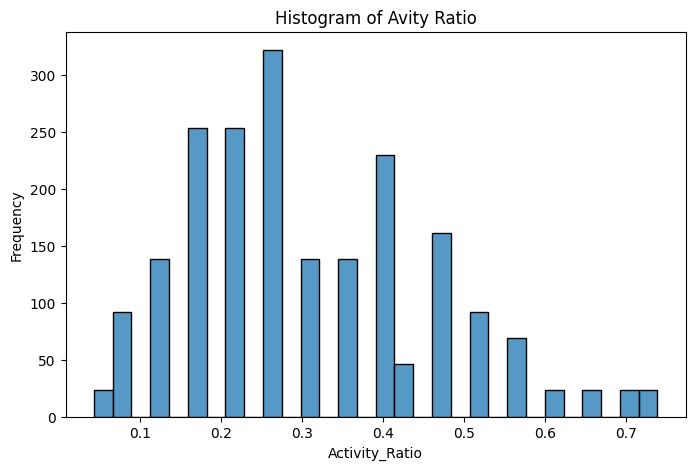

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(result_df["Activity_Ratio"], bins=30)

plt.title("Histogram of Avity Ratio")
plt.xlabel("Activity_Ratio")
plt.ylabel("Frequency")
plt.show()

Group those cases will help to better indentify the chellange

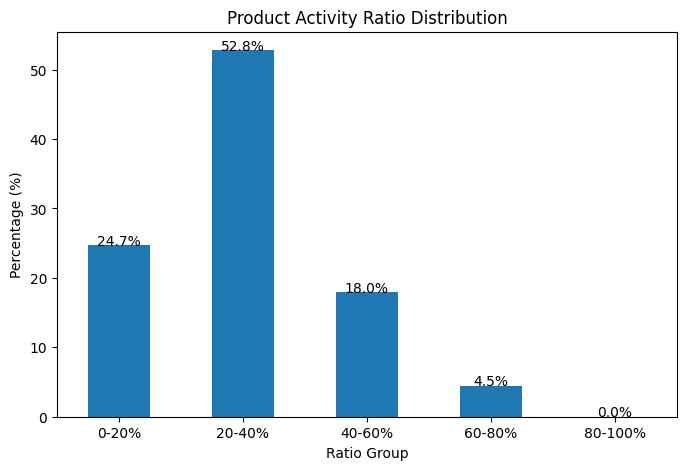

In [15]:
# If ratio is between 0 and 1, keep bins like this:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"]

# Create grouped variable
result_df["Activity_Group"] = pd.cut(
    result_df["Activity_Ratio"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Calculate percentage distribution
group_percent = (
    result_df["Activity_Group"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

# Plot
plt.figure(figsize=(8,5))
ax = group_percent.plot(kind="bar")

# Add percentage labels on bars
for i, v in enumerate(group_percent):
    ax.text(i, v, f"{v:.1f}%", ha="center")

plt.title("Product Activity Ratio Distribution")
plt.xlabel("Ratio Group")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)

plt.show()

## Correlation Matrix

The correlation matrix is a useful tool for identifying linear relationships between features. Although it does not necessarily indicate whether features are correlated in a way that affects models like deep learning, it provides valuable context and helps highlight simple, interpretable connections.

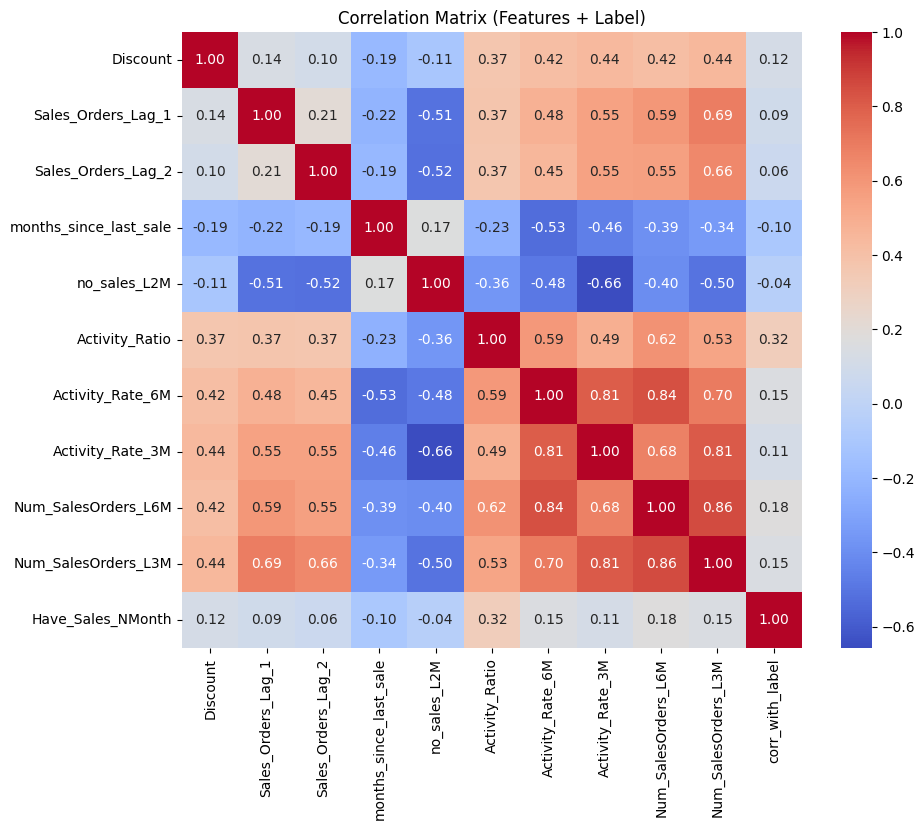

In [16]:
# Feature-feature correlations
cor_matrix = result_df[feature_cols].corr(method='pearson')

# Correlation with label
label_name = label_col[0]
label_corrs = result_df[feature_cols].apply(lambda x: x.corr(result_df[label_name]))

# Add as a column
cor_matrix["corr_with_label"] = label_corrs

# Add label row
label_row = label_corrs.tolist() + [1.0]
cor_matrix.loc[label_name] = label_row

plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (Features + Label)")
plt.show()

# Splitting Training and Validation & Scaling features

Since this is a time series problem, we will split the data based on dates, keeping the most recent rows for validation to prevent data leakage.

In [17]:
# Split train and val
split_date = pd.to_datetime('2015-01-01')
train_df = result_df[result_df['Date'] < split_date]
val_df = result_df[result_df['Date'] >= split_date]

In [18]:
from sklearn.preprocessing import StandardScaler

# Select features + label (Pandas)
train_pd = train_df[feature_cols + label_col].copy()
val_pd = val_df[feature_cols + label_col].copy()

# drop NA's
train_pd = train_pd.dropna()
val_pd = val_pd.dropna()

# Separate X and y
X_train = train_pd[feature_cols].values
Y_train = train_pd[label_col[0]].values

X_val = val_pd[feature_cols].values
Y_val = val_pd[label_col[0]].values

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [19]:
import numpy as np
print("Shape X:", X_train.shape)
print("Shape y:", Y_train.shape)

print("NaNs X:", np.isnan(X_train).sum())
print("NaNs y:", np.isnan(Y_train).sum())

print("Unique y:", np.unique(Y_train))
print("Positive rate:", np.mean(Y_train))

print("Max X:", np.max(X_train))
print("Min X:", np.min(X_train))

Shape X: (1424, 10)
Shape y: (1424,)
NaNs X: 0
NaNs y: 0
Unique y: [0 1]
Positive rate: 0.3026685393258427
Max X: 10.586407456532315
Min X: -1.7766296330789277


# Naive Baselines

Naive baselines provide a reference for AUC and accuracy by using simple, straightforward rules without any complex modeling.

## Always predict 1 (will be a sale)

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

y_pred_all1 = np.ones(len(Y_val))

acc_all1 = accuracy_score(Y_val, y_pred_all1)
print("Accuracy - Always 1:", acc_all1)

auc_all1 = roc_auc_score(Y_val, y_pred_all1)
print("AUC - Always 1:", auc_all1)

Accuracy - Always 1: 0.3325842696629214
AUC - Always 1: 0.5


## Rule: months_since_last_sale > 3 → predict 0

In [21]:
y_pred_rule_3 = (val_pd["months_since_last_sale"] <= 3).astype(int)

acc_rule_3 = accuracy_score(Y_val, y_pred_rule_3)
print("Accuracy - Rule >3:", acc_rule_3)

auc_rule_3 = roc_auc_score(Y_val, y_pred_rule_3)
print("AUC - Rule <=3:", auc_rule_3)

Accuracy - Rule >3: 0.4067415730337079
AUC - Rule <=3: 0.5301324051324052


## Rule: months_since_last_sale > 2 → predict 0

In [22]:
y_pred_rule_2 = (val_pd["months_since_last_sale"] <= 2).astype(int)

acc_rule_2 = accuracy_score(Y_val, y_pred_rule_2)
print("Accuracy - Rule >2:", acc_rule_2)

auc_rule_2 = roc_auc_score(Y_val, y_pred_rule_2)
print("AUC - Rule <=2:", auc_rule_2)

Accuracy - Rule >2: 0.42247191011235957
AUC - Rule <=2: 0.52496814996815


# Deep Learning

Even though traditional models like logistic regression or tree-based methods currently perform well on this small, intermittent-sales dataset, implementing deep learning is still worthwhile for several reasons.<br></br>
Deep learning excels at learning complex, nonlinear patterns and interactions between features that may not be obvious or manually engineered, which could capture subtle behaviors in customer purchasing.<br></br>
As more data is collected over time such as longer purchase histories, additional customer characteristics, or categorical information, deep learning models can leverage this growth effectively, scaling better than linear models.<br></br>
Moreover, deep architectures can automatically extract non-derivative, high-level features from raw inputs, reducing the need for extensive manual feature engineering and enabling the discovery of patterns that might otherwise remain hidden, ultimately improving predictive power and adaptability to new, richer datasets in the future.

In [23]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import regularizers

model = Sequential([
    Dense(10, activation="relu", input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.1),
    # Dense(10, activation="relu"),
    # Dropout(0.2),
    Dense(5, activation="relu"),
    Dense(1, activation = "sigmoid")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["AUC", "accuracy"]
)

In [25]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights automatically
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

# Make it a dictionary
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(0.7170191339375629), 1: np.float64(1.6519721577726219)}


In [26]:
early_stop = EarlyStopping(monitor='val_AUC',mode='max', patience=15, restore_best_weights=True)

lr_reduce = ReduceLROnPlateau(
    monitor='val_AUC',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 0.5146 - accuracy: 0.4794 - loss: 0.6911 - val_AUC: 0.5370 - val_accuracy: 0.4607 - val_loss: 0.6911
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.5583 - accuracy: 0.5164 - loss: 0.6871 - val_AUC: 0.5698 - val_accuracy: 0.4764 - val_loss: 0.6844
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5947 - accuracy: 0.5639 - loss: 0.6725 - val_AUC: 0.5721 - val_accuracy: 0.4787 - val_loss: 0.6836
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.5926 - accuracy: 0.5532 - loss: 0.6763 - val_AUC: 0.5802 - val_accuracy: 0.4854 - val_loss: 0.6848
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6096 - accuracy: 0.5670 - loss: 0.6683 - val_AUC: 0.5860 - val_accuracy: 0.4876 - val_loss: 0.6849
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.6051 - accuracy: 0.5793 - loss: 0.6931 - val_AUC: 0.5913 - val_accuracy: 0.4944 - val_loss: 0.6846
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515 (2.02 KB)

 Trainable params: 171 (684.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 344 (1.35 KB)

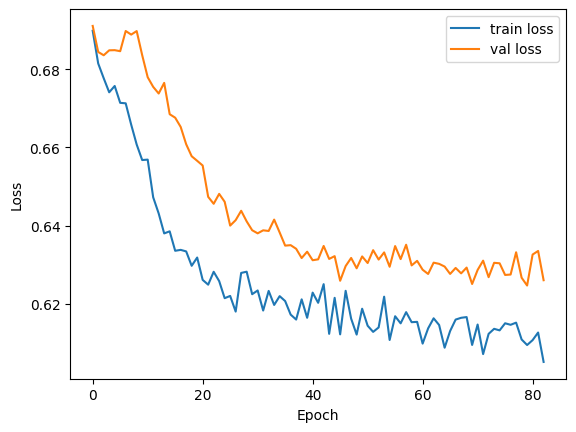

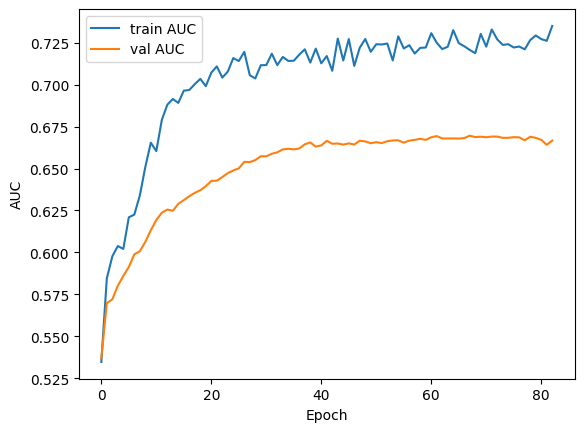

In [28]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['AUC'], label='train AUC')
plt.plot(history.history['val_AUC'], label='val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [29]:
loss, auc, acc = model.evaluate(X_val, Y_val)
lossT, aucT, accT = model.evaluate(X_train, Y_train)

print("Train Loss: ", lossT)
print("Train Auc: ", aucT)
print("Train Accuracy: ", accT)

print("Validation Loss: ", loss)
print("Validation Auc: ", auc)
print("Validation ACcuracy: ", acc)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6711 - accuracy: 0.6347 - loss: 0.6224 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7272 - accuracy: 0.7107 - loss: 0.5998
Train Loss:  0.6101891398429871
Train Auc:  0.7329006195068359
Train Accuracy:  0.6839887499809265
Validation Loss:  0.6277596950531006
Validation Auc:  0.669567346572876
Validation ACcuracy:  0.6269662976264954


In [30]:
from sklearn.metrics import accuracy_score

# Get probabilities from your model
y_pred_prob = model.predict(X_val).ravel()

# Try multiple thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)
    acc = accuracy_score(Y_val, y_pred)
    print(f"Threshold {t:.2f} → Accuracy {acc:.3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Threshold 0.10 → Accuracy 0.333
Threshold 0.15 → Accuracy 0.342
Threshold 0.20 → Accuracy 0.400
Threshold 0.25 → Accuracy 0.485
Threshold 0.30 → Accuracy 0.542
Threshold 0.35 → Accuracy 0.566
Threshold 0.40 → Accuracy 0.596
Threshold 0.45 → Accuracy 0.618
Threshold 0.50 → Accuracy 0.627
Threshold 0.55 → Accuracy 0.658
Threshold 0.60 → Accuracy 0.663
Threshold 0.65 → Accuracy 0.663
Threshold 0.70 → Accuracy 0.681
Threshold 0.75 → Accuracy 0.683
Threshold 0.80 → Accuracy 0.679
Threshold 0.85 → Accuracy 0.672


# Logistic Regression Method

<p>Logistic regression is a simple yet powerful model for binary classification. It estimates the probability of an outcome based on input features, performs well on small datasets, and is easy to interpret, making it a reliable baseline for predicting customer purchases.</p>

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

# Initialize model
log_model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Train
log_model.fit(X_train, Y_train)

# Get predicted probabilities
y_prob = log_model.predict_proba(X_val)[:, 1]

# Compute AUC
log_auc = roc_auc_score(Y_val, y_prob)
log_accuracy = accuracy_score(Y_val, y_pred)
logm_loss = log_loss(Y_val, y_prob)


print("Logistic Regression Validation AUC:", log_auc)
print("Log Loss:", logm_loss)
print("Accuracy:", log_accuracy)

Logistic Regression Validation AUC: 0.6827623077623077
Log Loss: 0.6112349943576662
Accuracy: 0.6719101123595506


In [32]:
# Extract coefficients
coefs = log_model.coef_[0]

# Create a DataFrame for easy viewing
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefs,
    'Abs_Coefficient': abs(coefs)
})

# Sort by absolute value to see most influential features
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

feature_importance

,Feature,Coefficient,Abs_Coefficient
5,Activity_Ratio,0.992460,0.992460
7,Activity_Rate_3M,-0.277691,0.277691
8,Num_SalesOrders_L6M,-0.170515,0.170515
9,Num_SalesOrders_L3M,0.121530,0.121530
6,Activity_Rate_6M,-0.104311,0.104311
3,months_since_last_sale,-0.092720,0.092720
1,Sales_Orders_Lag_1,0.071676,0.071676
0,Discount,0.038935,0.038935
2,Sales_Orders_Lag_2,-0.018597,0.018597
4,no_sales_L2M,0.015515,0.015515


## Random Forest Model

<p><strong>Random Forest</strong> is an ensemble of decision trees that improves prediction accuracy by averaging multiple trees. It handles non-linear relationships well, is robust to noisy data, and can automatically capture feature interactions, making it suitable for intermittent sales prediction.</p>

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced',
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

# Train
rf_model.fit(X_train, Y_train)

# Predict probabilities
rf_val_probs = rf_model.predict_proba(X_val)[:, 1]

# Class predictions (threshold 0.5)
rf_val_preds = (rf_val_probs >= 0.5).astype(int)

rf_auc = roc_auc_score(Y_val, rf_val_probs)
rf_acc = accuracy_score(Y_val, rf_val_preds)
rf_loss = log_loss(Y_val, rf_val_probs)

print("Random Forest Results")
print("AUC:", rf_auc)
print("Accuracy:", rf_acc)
print("Log Loss:", rf_loss)

Random Forest Results
AUC: 0.6423582673582674
Accuracy: 0.6269662921348315
Log Loss: 0.6444105471265569


## XBoost Model

<p><strong>XGBoost</strong> is a gradient boosting algorithm that builds trees sequentially to correct previous errors. It is highly effective for imbalanced and sparse datasets, offers regularization to prevent overfitting, and often achieves strong predictive performance with structured tabular data.</p>

In [34]:
from xgboost import XGBClassifier

ratio = (Y_train == 0).sum() / (Y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=500,
    scale_pos_weight=ratio,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="auc",
    early_stopping_rounds=30,
    use_label_encoder=False
)

xgb_model.fit(
    X_train,
    Y_train,
    eval_set=[(X_val, Y_val)],
    verbose=False
)

# Predict probabilities
xgb_val_probs = xgb_model.predict_proba(X_val)[:, 1]

# Class predictions (threshold 0.5)
xgb_val_preds = (xgb_val_probs >= 0.5).astype(int)

xgb_auc = roc_auc_score(Y_val, xgb_val_probs)
xgb_acc = accuracy_score(Y_val, xgb_val_preds)
xgb_loss = log_loss(Y_val, xgb_val_probs)

print("XGBoost Results")
print("AUC:", xgb_auc)
print("Accuracy:", xgb_acc)
print("Log Loss:", xgb_loss)

XGBoost Results
AUC: 0.6539835289835291
Accuracy: 0.6089887640449438
Log Loss: 0.6635931513429305


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [18:37:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


# Comparing All Models

In [35]:
results = pd.DataFrame({
    "Model": [
        "XGBoost",
        "Random Forest",
        "Logistic Regression",
        "Deep Learning"
    ],
    "AUC": [
        xgb_auc,
        rf_auc,
        log_auc,
        auc
    ],
    "Accuracy": [
        xgb_acc,
        rf_acc,
        log_accuracy,
        acc
    ],
    "Loss": [
        xgb_loss,
        rf_loss,
        logm_loss,
        loss
    ]
})

results.sort_values(by="AUC", ascending=False)

,Model,AUC,Accuracy,Loss
2,Logistic Regression,0.682762,0.671910,0.611235
3,Deep Learning,0.669567,0.671910,0.627760
0,XGBoost,0.653984,0.608989,0.663593
1,Random Forest,0.642358,0.626966,0.644411


<p>The results show that <strong>logistic regression</strong> currently achieves the best performance on this intermittent-sales dataset, with the highest AUC and solid accuracy, slightly outperforming deep learning, XGBoost, and random forest. <br></br>This indicates that the relationship between the features and the probability of a purchase is largely linear and can be captured effectively by a simpler model.<br></br> Deep learning performs comparably, suggesting it can learn subtle nonlinear patterns, but its advantage is limited by the small dataset.<br></br> XGBoost and random forest, while flexible and able to model complex interactions, underperform here, likely due to overfitting on noisy, sparse data. <br></br>With more data(longer customer histories, additional categorical information, and richer features)<strong> deep learning and ensemble methods would likely gain an edge</strong>, as they can better exploit complex patterns, automatically learn non-derivative features, and generalize more effectively to new customer behaviors.
<br></br>
Compared to naive models, we achieved a <strong>+20% increase in accuracy</strong>.